In [1]:
from scipy import io as scio
import numpy as np
import matplotlib.pyplot as plt
import skimage.transform as sktransform
from skimage.filters import threshold_otsu, threshold_sauvola
from skimage import feature
from tqdm import *
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

In [2]:
data = scio.loadmat('./mnist-original.mat')

In [3]:
img_data = data['data']
label_data = data['label']

In [4]:
img_data = img_data / 255

In [5]:
img_data.shape

(784, 70000)

In [6]:
label_data.shape

(1, 70000)

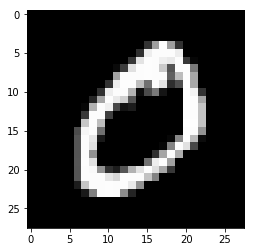

In [7]:
img_sample = np.reshape(img_data[:, 0], [28, 28])
plt.imshow(img_sample, cmap='gray')
plt.show()

In [8]:
dataset = img_data.T
label = label_data.T
print(dataset.shape)
print(label.shape)

(70000, 784)
(70000, 1)


In [9]:
def get_features_list(img):
    """
    Args:
        path : string :要进行特征提取的图片路径
    Return:
        feature_list : dict : 包含三种特征的字典
    """
    gray_image = img
    otsu_threshold = threshold_otsu(gray_image)
    bin_image = gray_image > otsu_threshold
    # 此处分别使用了水平、竖直、以及45 和135 度方向求 GLCM特征
#     feature_glcm = feature.greycomatrix(gray_image, [3], [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4], levels=256)
#     hog_feature_vector, hog_image = feature.hog(gray_image, orientations=8, pixels_per_cell=(5, 5),
#                                                 cells_per_block=(1, 1), visualize=True, block_norm='L2-Hys',
#                                                 feature_vector=True)
    # 设置LBP 特征提取算法的参数
    radius = 3
    n_points = 8 * radius
    #print(gray_image.dtype)
    feature_lbp = feature.local_binary_pattern(bin_image, n_points, radius, 'uniform')
#     feature_glcm_flattened = feature_glcm.flatten()
#     feature_hog_flattened = hog_feature_vector
    feature_lbp_flattended = feature_lbp.flatten()
    #result = {'glcm': feature_glcm_flattened, 'hog': feature_hog_flattened, 'lbp': feature_lbp_flattended}
    result = {'lbp': feature_lbp_flattended}
    return result

In [ ]:
clf = RandomForestClassifier(n_jobs=-1)

In [ ]:
lbp_feature = []
glcm_feature = []
hog_feature = []

In [ ]:
for img in tqdm(dataset):
    image = np.reshape(img, [28, 28])
    features = get_features_list(image)
    lbp_feature.append(features['lbp'])
#     lbp_feature.append(features['glcm'])
#     lbp_feature.append(features['hog'])

In [ ]:
lbp_feature = np.array(lbp_feature)

In [ ]:
lbp_feature.shape

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(lbp_feature, label, test_size=0.3, random_state=1, shuffle=True)

In [ ]:
clf.fit(X_train, y_train)

In [ ]:
clf.score(X_test, y_test)

In [ ]:
test_img = np.reshape(dataset[19999, :], [28, 28])
plt.imshow(test_img)
plt.show()

In [ ]:
lbp = get_features_list(test_img)['lbp']
lbp = np.reshape(lbp, [1, lbp.shape[0]])

In [ ]:
clf.predict(lbp)

In [ ]:
lbp_img = np.reshape(lbp, [28,28])
plt.imshow(lbp_img)
plt.show()

In [ ]:
pred = clf.predict(X_test)

In [ ]:
print(classification_report(y_test, pred))

### 使用keras 搭建一个简单的CNN 来实现分类

In [10]:
from keras.layers import Input, Conv1D, Conv2D, MaxPool1D, MaxPool2D, Softmax, GlobalAveragePooling2D, Dense,\
Dropout
from keras.optimizers import SGD
from keras.callbacks import TensorBoard, ReduceLROnPlateau, ModelCheckpoint
from keras.models import Model
from keras.utils import to_categorical
import os
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
os.environ["CUDA_VISIBLE_DEVICES"]="1"
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))

Using TensorFlow backend.


In [11]:
def get_model():
    input_tensor = Input(shape=(28, 28, 1))
    x = Conv2D(filters=64 ,kernel_size=(1,1) ,strides=(1, 1), activation='relu')(input_tensor)
    x = MaxPool2D(pool_size=(1, 1), strides=(2,2))(x)
    
    x = Conv2D(filters=128,kernel_size=(3,3), strides=(1, 1), activation='relu')(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)
    
    x = Conv2D(filters=256,kernel_size=(3,3), strides=(1, 1), activation='relu')(x)
    x = MaxPool2D(pool_size=(2, 2), strides=(2, 2))(x)     
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(256)(x)
    y = Dense(10,activation='softmax')(x)
    model = Model(input=input_tensor, outputs=y)
    sgd = SGD(lr=1e-2, momentum=0.9)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['acc'])
    return model

In [12]:
model = get_model()

/home/zyp/miniconda3/envs/pda/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("de..., inputs=Tensor("in...)`
  app.launch_new_instance()


In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 64)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 4, 4, 256)         295168    
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 2, 2, 256)         0         
__________

In [14]:
y_one_hot = to_categorical(label)
y_one_hot.shape

(70000, 10)

In [15]:
dataset_img = np.reshape(dataset, [dataset.shape[0], 28, 28, 1])

In [16]:
dataset_img.shape

(70000, 28, 28, 1)

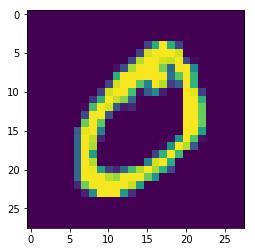

(<matplotlib.image.AxesImage at 0x7f1de00b7f28>, None)

In [17]:
plt.imshow(dataset_img[0][:,:,0]),plt.show()

In [18]:
from visualize_feature_map import MyTensorBoard

In [19]:
tb = TensorBoard(log_dir='./log', 
                 histogram_freq=10, 
                 batch_size=32
                )
model_save = ModelCheckpoint('./model/Mnist-CNN-model.h5',
                             monitor='val_loss',
                             verbose=100,
                             save_best_only=True,
                             save_weights_only=True, 
                             mode='auto',
                             period=10)
lr_reduce = ReduceLROnPlateau(monitor='val_loss', 
                              factor=0.1, 
                              patience=10,
                              verbose=0, 
                              mode='auto',
                              min_delta=0.0001, 
                              min_lr=1e-5)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(dataset_img, y_one_hot, test_size=0.3, random_state=1, shuffle=True)

In [21]:
X_train.shape

(49000, 28, 28, 1)

In [22]:
model.fit(X_train, y_train ,batch_size=400,epochs=20,verbose=1,validation_split=0.1,
         callbacks=[lr_reduce, model_save, tb])

Train on 44100 samples, validate on 4900 samples
Epoch 1/20
44100/44100 [==============================] - 5s 105us/step - loss: 2.2593 - acc: 0.2284 - val_loss: 2.1302 - val_acc: 0.5796
Epoch 2/20
44100/44100 [==============================] - 2s 47us/step - loss: 1.3073 - acc: 0.6033 - val_loss: 0.6639 - val_acc: 0.8051
Epoch 3/20
44100/44100 [==============================] - 2s 47us/step - loss: 0.4440 - acc: 0.8624 - val_loss: 0.2627 - val_acc: 0.9182
Epoch 4/20
44100/44100 [==============================] - 2s 44us/step - loss: 0.2975 - acc: 0.9100 - val_loss: 0.1878 - val_acc: 0.9451
Epoch 5/20
44100/44100 [==============================] - 2s 45us/step - loss: 0.2324 - acc: 0.9285 - val_loss: 0.1631 - val_acc: 0.9516
Epoch 6/20
44100/44100 [==============================] - 2s 46us/step - loss: 0.1891 - acc: 0.9426 - val_loss: 0.1885 - val_acc: 0.9371
Epoch 7/20
44100/44100 [==============================] - 2s 45us/step - loss: 0.1743 - acc: 0.9473 - val_loss: 0.1272 - val_acc

In [23]:
model.evaluate(X_test, y_test)

21000/21000 [==============================] - 1s 66us/step


[0.07511513172112227, 0.9758571428571429]

In [24]:
pred = model.predict(X_test)

In [25]:
import numpy as np

In [26]:
y_test_label = np.array([np.argmax(d) for d in y_test])
y_pre_label = np.array([np.argmax(d) for d in pred])

In [27]:
print(y_test_label.shape)
print(y_pre_label.shape)

(21000,)
(21000,)


In [28]:
from sklearn.metrics import accuracy_score

In [29]:
accuracy_score(y_test_label, y_pre_label)

0.9758571428571429

In [30]:
test_sample = X_test[1001, :, :, :]
test_sample = np.reshape(test_sample, [1, test_sample.shape[0], test_sample.shape[1], test_sample.shape[2]])
test_sample.shape

(1, 28, 28, 1)

In [31]:
test_result = model.predict(test_sample)
print(test_result)
print(np.argmax(test_result))

[[6.2369465e-09 4.4005267e-13 7.3837603e-10 1.9209171e-08 3.3837873e-11
  8.9808651e-08 3.0143916e-09 2.8137223e-13 9.9999952e-01 3.6349377e-07]]
8


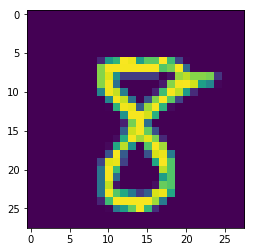

(<matplotlib.image.AxesImage at 0x7f1b400d7cc0>, None)

In [32]:
plt.imshow(test_sample[0, :,:, 0]),plt.show()

In [33]:
import keras.backend as K

In [34]:
K.clear_session()